# Train your custom YOLOv5 Visual Inspection model
*Based on and inspired by the  [Yolov5 Tutorials](https://github.com/ultralytics/yolov5/wiki/) by  [Ultralytics](https://ultralytics.com)*

In this notebook we are going to train a custom Yolov5 model for detecting anomalies in images. The data set for this demonstrator is based on wind turbine surface damage hosted on [kaggle.com](https://www.kaggle.com/datasets/ajifoster3/yolo-annotated-wind-turbines-586x371) 


A dataset of wind turbine surface damage composed of images from Shihavuddin & Chen's (2018) dataset, split into 586x371 pixel images with YOLO format annotations for Dirt and Damage. The dataset consists of 13000 images, just under 3000 of which have instances of one of the two classes.

**Source:** https://www.kaggle.com/datasets/ajifoster3/yolo-annotated-wind-turbines-586x371


**For academic works, please cite as:**
Foster, Ashley; Best, Oscar; Gianni, Mario; Khan, Asiya; Collins, Kerry; Sharma, Sanjay (2022),
"Drone Footage Wind Turbine Surface Damage Detection",
IEEE IVMSP 2022 (Accepted for publication)

**Original dataset:**

SHIHAVUDDIN, ASM; Chen, Xiao (2018),
“DTU - Drone inspection images of wind turbine”,
Mendeley Data,
V2,
doi: 10.17632/hd96prn3nc.2


**License:**
https://creativecommons.org/licenses/by-nc/4.0/
CC BY-NC 4.0 DEED
Attribution-NonCommercial 4.0 International



# Setup

Clone GitHub [repository](https://github.com/ultralytics/yolov5), install [dependencies](https://github.com/ultralytics/yolov5/blob/master/requirements.txt) and check PyTorch and GPU.

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
# %pip install -qr requirements.txt  # installation not required when using Windy Journey Notebook image

Cloning into 'yolov5'...
remote: Enumerating objects: 16525, done.
remote: Total 16525 (delta 0), reused 0 (delta 0), pack-reused 16525
Receiving objects: 100% (16525/16525), 15.00 MiB | 14.07 MiB/s, done.
Resolving deltas: 100% (11361/11361), done.
/opt/app-root/src/windy-journey/ml/pytorch/yolov5


/opt/app-root/lib64/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Install opencv-python-headless

In [2]:
# !pip install opencv-python-headless # installation not required when using Windy Journey Notebook image

Just in case you notebook stopped or crashed, you cant start here but ensure that you are in the tight directory

In [15]:
%cd /opt/app-root/src/windy-journey/ml/pytorch/yolov5

/opt/app-root/src/windy-journey/ml/pytorch/yolov5


In [3]:
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.9.18 torch-2.0.1+cu118 CPU


Setup complete ✅ (24 CPUs, 125.6 GB RAM, 167.9/278.9 GB disk)


# Test the setup 

`detect.py` runs YOLOv5 inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases), and saving results to `runs/detect`. Example inference sources are:

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image 
                          vid.mp4  # video
                          screen  # screenshot
                          path/  # directory
                         'path/*.jpg'  # glob
                         'https://youtu.be/Zgi9g1ksQHc'  # YouTube
                         'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.9.18 torch-2.0.1+cu118 CPU

100%|██████████████████████████████████████| 14.1M/14.1M [00:00<00:00, 89.2MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /opt/app-root/src/windy-journey/ml/pytorch/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 376.1ms
image 2/2 /opt/app-root/src/windy-journey/ml/pytorch/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, 263.6ms
Speed: 1.7ms pre-process, 319.8ms inference, 1.3ms NMS per image at shape (1,

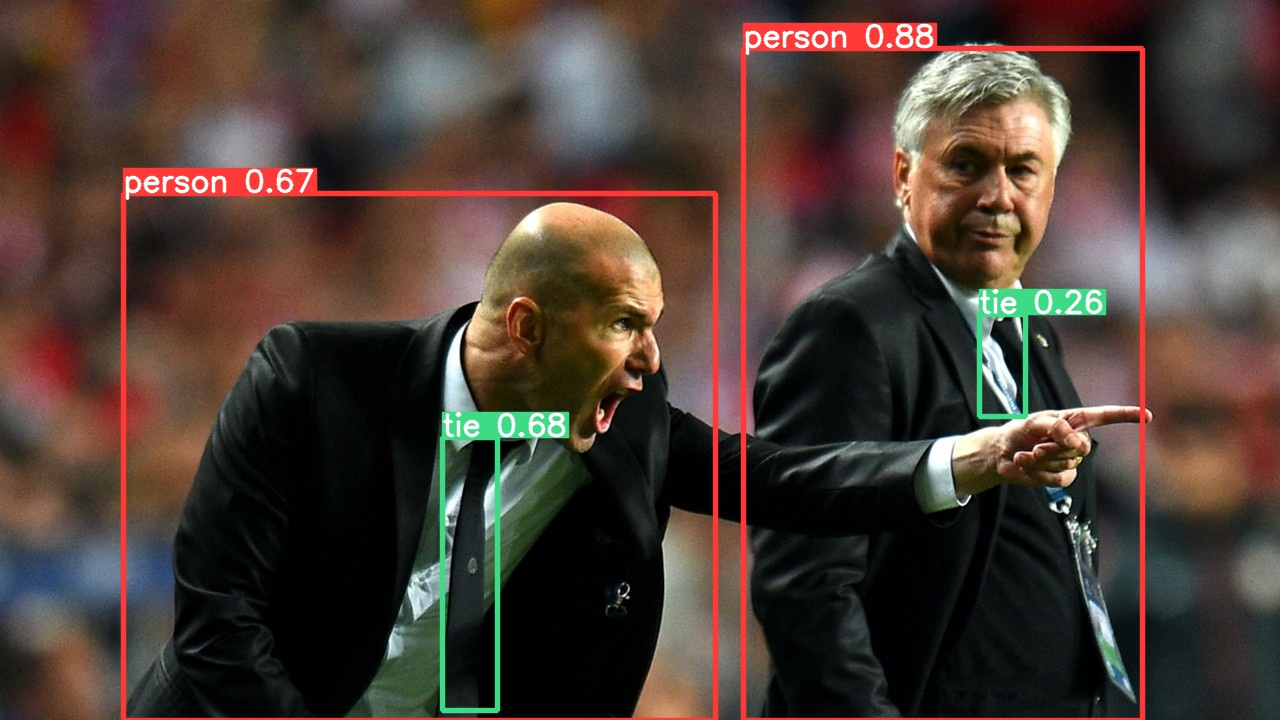

In [4]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images
display.Image(filename='runs/detect/exp/zidane.jpg', width=600)

/opt/app-root/src/windy-journey/ml/pytorch/yolov5# What are YOLO v5 Annotations?
Before starting the model training, let's have a brief look at the required annotations.


## YOLO v5 Annotation Format
YOLO v5 expects annotations for each image in form of a .txt file where each line of the text file describes a bounding box. Consider the following image:

![zidane](images/zidane.jpg)

The annotation file for the image above looks like the following:

![zidane-txt](images/zidane-txt.png)

There are 3 objects in total (2 persons and one tie). Each line represents one of these objects. The specification for each line is as follows:

- One row per object
- Each row is class x_center y_center width height format.
- Box coordinates must be normalized by the dimensions of the image (i.e. have values between 0 and 1)
- Class numbers are zero-indexed (start from 0).

Source: [train-yolov5-custom-data](https://blog.paperspace.com/train-yolov5-custom-data/#convert-the-annotations-into-the-yolo-v5-format)

# Data preparation
Data preparation is usually a big task. You might have to clean the data. Label the data - in computer vision it means creating the bounding boxes. And also split the data into training and test data sets.

We are lucky, because this (hard) work has been done already. You just need to download and unpack the images and annotations. 

**Unzip the images and annotations:**

In [5]:
!pwd
!curl -LO https://github.com/sa-mw-dach/windy-journey/releases/download/v0.0.0/annotated-wind-turbine-surface-damage-200.tar.gz

/opt/app-root/src/windy-journey/ml/pytorch/yolov5
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 37.5M  100 37.5M    0     0  17.3M      0  0:00:02  0:00:02 --:--:-- 31.2M


In [6]:
!tar zxf annotated-wind-turbine-surface-damage-200.tar.gz -C data

In [7]:
!ls -l data/wind-turbine

total 20
-rw-r--r--. 1 1000870000 1000870000  106 Oct 31 07:35 data.yaml
-rw-r--r--. 1 1000870000 1000870000  929 Oct 31 07:40 README.txt
drwxr-sr-x. 4 1000870000 1000870000 4096 Oct 31 07:35 test
drwxr-sr-x. 4 1000870000 1000870000 4096 Oct 31 07:35 train
drwxr-sr-x. 4 1000870000 1000870000 4096 Oct 31 07:35 valid


In [8]:
!find data/wind-turbine -type d

data/wind-turbine
data/wind-turbine/train
data/wind-turbine/train/images
data/wind-turbine/train/labels
data/wind-turbine/test
data/wind-turbine/test/images
data/wind-turbine/test/labels
data/wind-turbine/valid
data/wind-turbine/valid/images
data/wind-turbine/valid/labels


**View a example image:** 

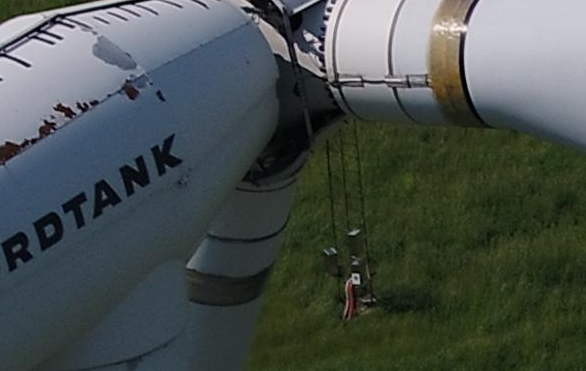

In [9]:
# View image 
display.Image(filename='data/wind-turbine/train/images/DJI_0021_03_04.png', width=600)

**Explore the Yolo annotation for the image:**

Let's have look at the annotation file for the image. It contains several damages:

In [10]:
# Show annotation
!cat data/wind-turbine/train/labels/DJI_0021_03_04.txt

1 0.195392 0.142857 0.080205 0.097035
1 0.232082 0.230458 0.047782 0.067385
1 0.162116 0.276280 0.017065 0.024259
1 0.139932 0.285714 0.020478 0.026954
1 0.109215 0.295148 0.044369 0.045822
1 0.081058 0.345013 0.032423 0.048518
1 0.034130 0.409704 0.068259 0.070081
1 0.313993 0.479784 0.023891 0.053908

# Start model training 
Train a YOLOv5m model on the metal-nut data by specifying dataset, batch-size, image size and pretrained --weights yolov5m.pt. Pretrained weights are auto-downloaded from the latest [YOLOv5 release](https://github.com/ultralytics/yolov5/releases).

**Important:** At Summit 2024, we are using only CPUs. Training will not finsih in any reasonale time without GPUs. Please start the training, but press the stop button (interrupt the kernel) when you see the 1st epoch runnung:
```
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
  0%|          | 0/10 [00:00<?, ?it/s]

```


In [4]:
!python train.py --img 640 --batch 16 --epochs 1 --data data/wind-turbine/data.yaml --weights yolov5m.pt --workers 0

train: weights=yolov5m.pt, cfg=, data=data/wind-turbine/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=0, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.9.18 torch-2.0.1+cu118 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_p

# Test the (pre-) trained model


Due to resource or time constraints, it was not possible to complete the model training.

No worries, next you will download a pre-trained model and set a MODEL env variable to the pre-rained model file. 


Double check that the note is still in the directory `/opt/app-root/src/windy-journey/ml/pytorch/yolov5`


In [8]:
%cd /opt/app-root/src/windy-journey/ml/pytorch/yolov5

/opt/app-root/src/windy-journey/ml/pytorch/yolov5


Download the pre-tained model

In [10]:
!curl -L https://github.com/sa-mw-dach/windy-journey/releases/download/v0.0.0/weights-best-2023_10_31-01_42.pt --output runs/model.pt

%env MODEL=runs/model.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  159M  100  159M    0     0  66.6M      0  0:00:02  0:00:02 --:--:-- 89.7M
env: MODEL=runs/model.pt


## Test the model
First, run `python detect.py` with a sample image:

In [11]:
!python detect.py --weights $MODEL --img 640 --conf 0.25 --source data/wind-turbine/train/images/DJI_0021_03_04.png


detect: weights=['runs/model.pt'], source=data/wind-turbine/train/images/DJI_0021_03_04.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.9.18 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
image 1/1 /opt/app-root/src/windy-journey/ml/pytorch/yolov5/data/wind-turbine/train/images/DJI_0021_03_04.png: 416x640 10 damages, 688.6ms
Speed: 1.3ms pre-process, 688.6ms inference, 1.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


The last output line should contain `Results saved to runs/detect/exp2`. Please note the number of the exp and update the next cell before running the next cell.

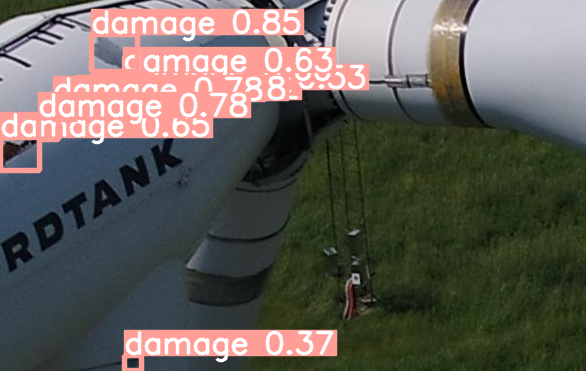

In [12]:
display.Image(filename='runs/detect/exp2/DJI_0021_03_04.png', width=600)

# Export YoloV5 model to ONNX format
Source: [01-yolov5_to_onnx.ipynb](https://github.com/rh-aiservices-bu/yolov5-model-serving/blob/main/01-yolov5_to_onnx.ipynb)
* Eventually modify the image size if you selected  a model with the "6" suffix, as image size is 1280 (and not 640)
* Stay at opset 16 for the moment for OpenVino model server compatibility

Please check again if you need to change `exp` to your latest run number. E.g. `exp[1-7]`.

In [13]:
!python export.py --weights $MODEL --include onnx --imgsz 640 --opset 16

export: data=data/coco128.yaml, weights=['runs/model.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, simplify=False, opset=16, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.9.18 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs

PyTorch: starting from runs/model.pt with output shape (1, 25200, 7) (160.0 MB)

ONNX: starting export with onnx 1.15.0...
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: export success ✅ 2.4s, saved as runs/model.onnx (80.0 MB)

Export complete (5.4s)
Results saved to /opt/app-root/src/windy-journey/ml/pytorch/yo

# Summary
We hat a look that the labeled data and used Ultralytics Yolov5 to train and text a model. Addtionally, we exported the model to ONNX so that is can be served with RHOAI.   